In [5]:
import numpy as np
import cv2
from skimage import io
from matplotlib import pyplot as plt
import pytesseract
from pytesseract import Output
from multiprocessing import Pool
import multiprocessing
import pandas as pd
from pathos.threading import ThreadPool
img = io.imread("./data/snapshot.jpeg")
img = img[500:,250:1500]

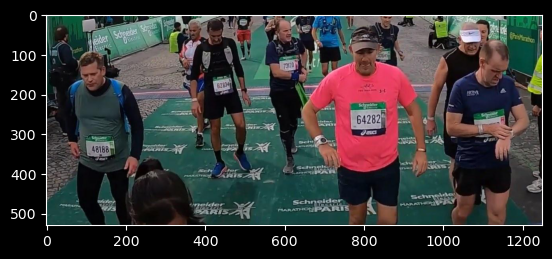

In [6]:
plt.imshow(img)

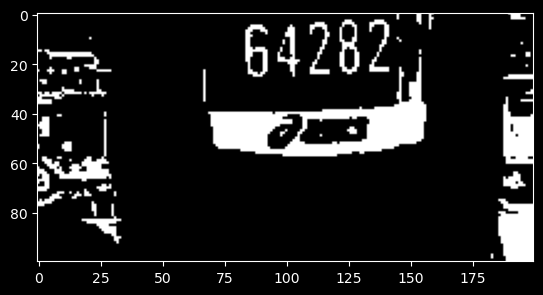

In [7]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# plt.imshow(gray, cmap='gray')
bh = cv2.morphologyEx(threshed, cv2.MORPH_BLACKHAT, (1,1))
plt.imshow(threshed[250:350,700:900],cmap='gray')

[INFO] loading the detector...
[INFO] detection in 0.68 seconds


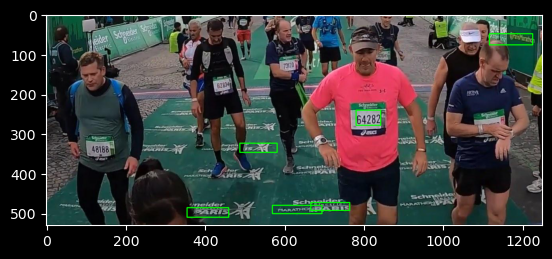

In [16]:
from utils import forward_passer, box_extractor
from imutils.object_detection import non_max_suppression
detector = "east"
min_confidence = 0.5
image = threshed

def resize_image(image, width, height):
    """
    Re-sizes image to given width & height
    :param image: image to resize
    :param width: new width
    :param height: new height
    :return: modified image, ratio of new & old height and width
    """
    h, w = image.shape[:2]

    ratio_w = w / width
    ratio_h = h / height

    image = cv2.resize(image, (width, height))

    return image, ratio_w, ratio_h


def find_text(image, width, height, detector, min_confidence):

    # reading in image
    orig_image = image.copy()

    # resizing image
    image, ratio_w, ratio_h = resize_image(image, width, height)

    # layers used for ROI recognition
    layer_names = ['feature_fusion/Conv_7/Sigmoid',
                   'feature_fusion/concat_3']

    # pre-loading the frozen graph
    print("[INFO] loading the detector...")
    net = cv2.dnn.readNet(detector)

    # getting results from the model
    scores, geometry = forward_passer(net, image, layers=layer_names)

    # decoding results from the model
    rectangles, confidences = box_extractor(scores, geometry, min_confidence)

    # applying non-max suppression to get boxes depicting text regions
    boxes = non_max_suppression(np.array(rectangles), probs=confidences)

    # drawing rectangles on the image
    for (start_x, start_y, end_x, end_y) in boxes:
        start_x = int(start_x * ratio_w)
        start_y = int(start_y * ratio_h)
        end_x = int(end_x * ratio_w)
        end_y = int(end_y * ratio_h)

        cv2.rectangle(orig_image, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
    
    plt.imshow(orig_image)
    
find_text(img, 320, 320, 'frozen_east_text_detection.pb', 0.5)

TypeError: can only concatenate list (not "int") to list

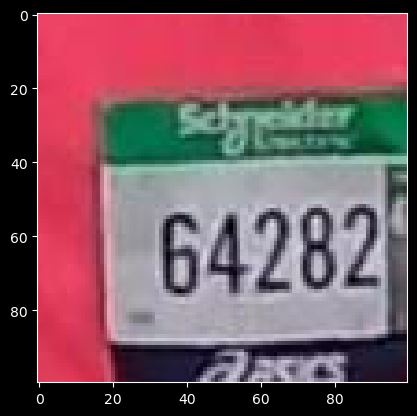

In [60]:

def build_tesseract_options(psm):
    alphanumeric = "0123456789"
    options = f"-c tessedit_char_whitelist={alphanumeric}" 
    options += "-c tessedit_char_blacklist="., " 
    options += " --psm {}".format(psm)
    return options

def perform_ocr(roi):
    ocr_options = build_tesseract_options(psm=3)
    df = pytesseract.image_to_data(
        roi, config=ocr_options, output_type=Output.DATAFRAME
    )
    return df

img = io.imread("./data/snapshot.jpeg")
crop = img[700:800, 1000:1100]
# crop = cv2.rotate(crop, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(crop)

In [66]:
ocr_options = build_tesseract_options(psm=10)
df = pytesseract.image_to_data(
    crop, config=ocr_options,lang='eng', output_type=Output.DATAFRAME
)
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,100,100,-1.000000,NaN
1,2,1,1,0,0,0,19,41,81,59,-1.000000,NaN
2,3,1,1,1,0,0,19,41,81,59,-1.000000,NaN
3,4,1,1,1,1,0,19,41,81,59,-1.000000,NaN
4,5,1,1,1,1,1,19,41,81,59,61.561607,64282.0


In [67]:
a = 10
if 5 < a < 20:
    print(a)

10


In [11]:
%%timeit
rois = np.vsplit(crop,5)
df_list = []
for roi in rois:
    df = perform_ocr(roi)
    df_list.append(df)

res_df = pd.concat(df_list)

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN
0,1,1,0,0,0,0,0,0,40,16,-1.0,NaN


In [18]:
%%timeit
rois = np.vsplit(crop,5)
pool = ThreadPool(nodes=8)
# df_list = pool.map(perform_ocr, rois)
df_list = list(pool.imap(perform_ocr, rois))
res_df = pd.concat(df_list)

625 ms ± 77.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
int("")

ValueError: invalid literal for int() with base 10: ''

In [ ]:
gray = cv2.cvtColor(crop, cv2.COLOR_RGB2GRAY)
bh = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, (13, 5))
plt.imshow(bh, cmap='gray')

In [ ]:
threshed = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
plt.imshow(threshed, cmap='gray')

In [ ]:


options = build_tesseract_options(psm=1)
df_results = pytesseract.image_to_data(threshed, config=options, output_type=Output.DATAFRAME)
print(df_results)
# pytesseract.image_to_boxes(threshed, config="-c tessedit_char_whitelist=0123456789")
# pytesseract.image_to_string(threshed)

In [ ]:
io.imsave("test.png", threshed)
pytesseract.image_to_osd(r'C:\Users\User\Desktop\MarathonVision\test.png', config='--psm 8 -c min_characters_to_try=5')

In [ ]:
res = pd.concat([df_results, df_results])